In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt 
from scipy.io import loadmat, savemat
import seaborn
seaborn.set_style('whitegrid')

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [3]:
from tensorflow import keras
Dense = keras.layers.Dense
Dropout = keras.layers.Dropout
maxnorm = keras.constraints.max_norm
SGD = keras.optimizers.SGD 


E:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Uncertain Initial Altitude
Train a network exclusively on initial altitude for all outputs

In [5]:
X = []
Y = []
for file in os.listdir("./data/mae278/alt_sweep_fixed"):
    if not file.endswith('.mat'):
        continue
    data = loadmat("./data/mae278/alt_sweep_fixed/"+file, squeeze_me=True)
    x = data['state']
    L = data['costate']
    y = L[0]
#     y = np.append(y, data['time'][-1])
    
    X.append(x[0,2]) # initial altitude
    Y.append(y)
X = np.array(X)
Y = np.array(Y)
  

input_scaler = StandardScaler()
output_scaler = StandardScaler()

Xs = input_scaler.fit_transform(X.reshape(-1, 1))
Ys = output_scaler.fit_transform(Y)
print(np.shape(Xs))
print(np.shape(Ys))  

(101, 1)
(101, 7)


In [26]:
model = keras.models.Sequential()
n_dim = 1 
n_neurons = 50
model.add(Dense(units=n_neurons, activation='relu', input_dim=n_dim)) # Input shape must be specified for the input layer 
# model.add(Dropout(rate=0.1))
model.add(Dense(units=n_neurons, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(units=n_neurons, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(units=n_neurons, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(units=n_neurons, activation='relu'))
# model.add(Dropout(rate=0.5))
# model.add(Dense(units=n_neurons, activation='relu', kernel_constraint=maxnorm(10)))
model.add(Dense(units=7, activation='linear')) # Output layer, linear for regression 

model.compile(loss='mean_squared_error', optimizer='adam') # adam proved much more useful than sgd
history = model.fit(Xs, Ys, epochs=500, verbose=False, validation_split=0.4)

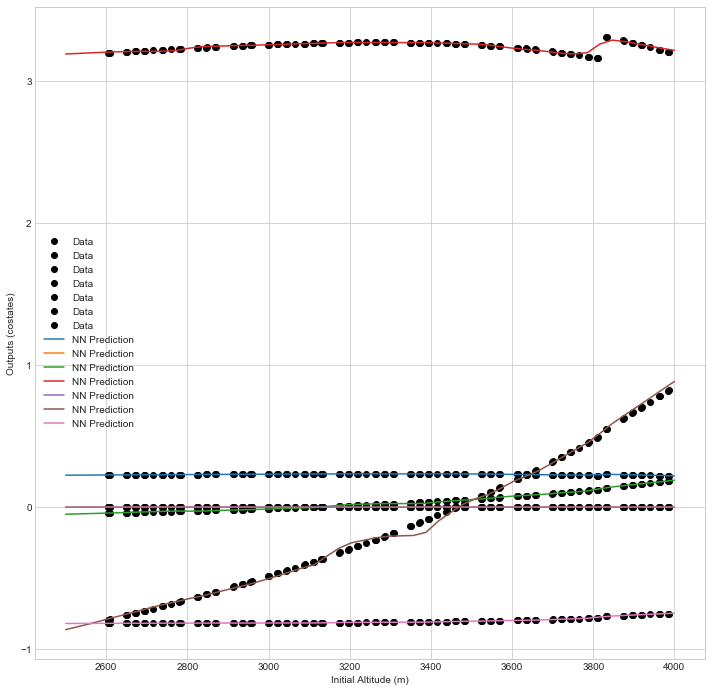

In [27]:
X_test = np.linspace(2500, 4000)
X_test_scaled = input_scaler.transform(X_test[:,None])
y_test_scaled = model.predict(X_test_scaled)
y_test = output_scaler.inverse_transform(y_test_scaled)

plt.figure(figsize=(12,12))
plt.plot(X, Y, 'ko',label='Data')
plt.plot(X_test, y_test,label='NN Prediction')
plt.xlabel('Initial Altitude (m)')
plt.ylabel('Outputs (costates)')
plt.legend()

## Uncertainty in initial position and velocity
Now consider the full problem where the entire initial state $\in\mathbb{R}^6$ (except the mass of the vehicle) can vary within a hyper-rectangle given by:

- Initial range to target $\in[-4200, -2800]$ m
- Initial crossrange to target $\in[-2000, -2000]$ m
- Initial altitude $\in[2600, 4000]$ m
- Initial downrange velocity $\in[585, 725]$ m/s
- Initial crossrange velocity $\in[-100, 100]$ m/s
- Initial vertical velocity $\in[-310, -230]$ m/s


In [ ]:
x0 = [-3200., 0., 3200., 625., 0., -270., 8500.]
ux = cp.Uniform(x0[0]-1200,x0[0]+400)
uy = cp.Uniform(x0[1]-2000,x0[1]+2000)
uz = cp.Uniform(x0[2]-600,x0[2]+800)
# uu = cp.Uniform(x0[3]-40,x0[3]+100)
# uv = cp.Uniform(x0[4]-100,x0[4]+100)
# uw = cp.Uniform(x0[5]-40,x0[5]+40)

In [ ]:
X = []
Y = []
for file in os.listdir("./data/mae278/"):
    if not file.endswith('.mat'):
        continue
    data = loadmat("./data/mae278/"+file, squeeze_me=True)
    x = data['state']
    L = data['costate']
    y = L[0]
#     y = np.append(y, data['time'][-1])
    
    X.append(x[0]) # initial altitude
    Y.append(L[0])
X = np.array(X)
Y = np.array(Y)
  

input_scaler = StandardScaler()
output_scaler = StandardScaler()

Xs = input_scaler.fit_transform(X.reshape(-1, 1))
Ys = output_scaler.fit_transform(Y.reshape(-1, 1))
print(np.shape(Xs))
print(np.shape(Ys))  

## Non EDL Test
Define a test function and some data

In [41]:
N = 5000
x = np.linspace(-1,1, N) 
y = -1 + 2*np.random.random((N,)) 
X = np.stack((x,y))
f = 0.2*np.sin(x) + 0.3*np.cos(y) + 0.01*np.random.random((N,))

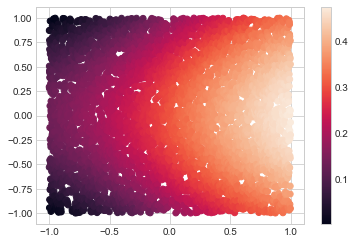

In [42]:
plt.scatter(x,y,c=f)
plt.colorbar()

Define a feedforward neural network 

In [43]:
model = keras.models.Sequential()
n_layers = 3 # Number of hidden layers -  does not include input/output 
n_dim = 2 
n_neurons = 20
model.add(Dense(units=n_neurons, activation='relu', input_dim=n_dim)) # Input shape must be specified for the input layer 
model.add(Dropout(units=n_neurons, activation='relu'))
model.add(Dense(units=1, activation='linear')) # Output layer, linear for regression 

# for i in range(n_layers):
#     model.add(Dense(units=n_neurons, activation='relu', input_dim=n_dim))

# model.add(Dense(units=10, activation='softmax')) # Output layer 

In [45]:
model.compile(loss='mean_squared_error', optimizer='sgd')
model.fit(X.T, f, epochs=200, validation_split=0.1, verbose=False)

In [46]:
N_test = 5000
x = np.linspace(-1,1, N) 
y = -1 + 2*np.random.random((N,)) 
X_test = np.stack((x,y)).T
f = 0.2*np.sin(x) + 0.3*np.cos(y)
f_test = model.predict(X_test)

Text(0.5,1,'Error heat map')

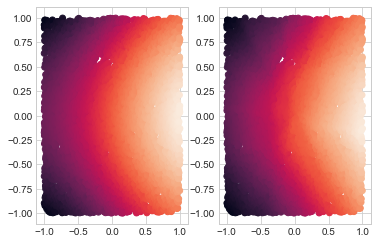

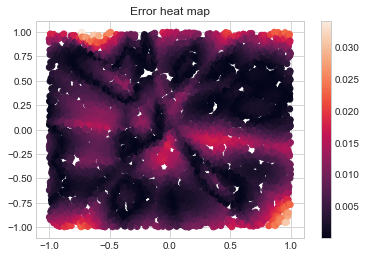

In [47]:
plt.figure()
plt.subplot(121)
plt.scatter(x,y,c=f)
plt.subplot(122)
plt.scatter(x,y,c=f_test.squeeze())

plt.figure()
plt.scatter(x,y,c=np.abs(f-f_test.squeeze()))
plt.colorbar()
plt.title('Error heat map')